# Twitter Sentiment Analysis with Sentiment140 Dataset

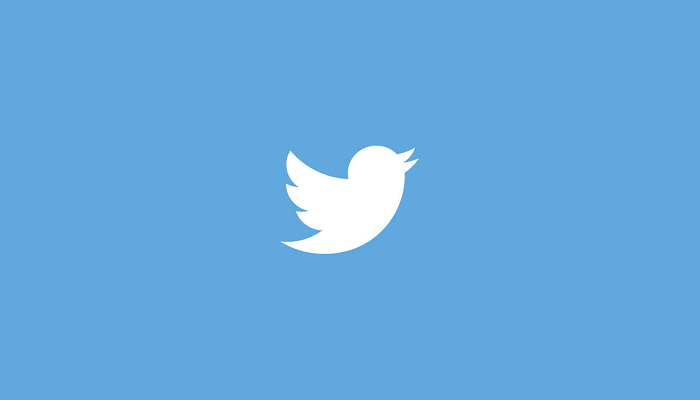

## Introduction

<b>Sentiment Analysis</b> is one of the key applications of <b>Natural Language Processing (NLP)</b>, which is an interdisciplinary field that sits at the intersection of artificial intelligence and linguistics. NLP is primarily concerned with the automatic processing and understanding of natural language by computers, and a sentiment analysis model is a model that is able to predict if a given piece of text expresses a positive or negative sentiment.

In this notebook, we will attempt to train a sentiment analysis model using the Sentiment140 dataset, which is a collection of 1.6 million annotated tweets.

## Business Problem

As more and more consumers shift to digital and spend more time online, it has become increasingly important for brands to engage with their customers online using social media platforms such as Facebook, Instagram and Twitter. These public platforms contain lots of customer reviews regarding the brands' products or services, and they tend to have a huge impact on potential customers' purchasing decisions. Negative reviews on a brand's social media presence will no doubt have a significant damaging impact on the company's sales and reputation.

Hence, it is imperative for companies to accurately identify the public sentiment towards their brands in real time. This will then allow them to come up with timely strategic changes and key improvements to their products or services which will help in maximising customer satisfaction.

## Data

The dataset of 1.6 million annotated tweets was obtained from: http://help.sentiment140.com/

> <i>Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search.</i>

## Approach

Text preprocessing is one of the key steps in training a sentiment analysis model. Before feeding the tweets into the model, we need to first clean and transform the raw text into a more easily digestible form that can work better with machine learning algorithms. This will involve common steps such as tokenisation, lemmatisation and stop word removal, as well as Twitter-specific steps that deal with URLs and mentions ("@") within the tweets.

Once the text has been preprocessed, we can start to train our sentiment analysis model using either one of two approaches:

1. <b>Term Frequency-Inverse Document Frequency (TF-IDF)</b>
2. <b>Word Embedding</b>

<b>TF-IDF</b> is an old-school method that is used to reflect the importance of each word in a tweet in relation to the entire collection of tweets using the product of two statistics, namely TF and IDF, while <b>word embedding</b> aims to represent words using vectors of real numbers, where similar words will have similar vector representations. In this notebook, we will attempt both methods and compare their results.

## Table of Contents

1. [Import libraries and data](#head-1)  
2. [Text preprocessing](#head-2)  
 2.1. [URLs](#head-21)  
 2.2. [Mentions](#head-22)  
 2.3. [Punctuations](#head-23)  
 2.4. [Consecutive letters](#head-24)  
 2.5. [Lower case](#head-25)  
 2.6. [Stop word removal](#head-26)  
 2.7. [Lemmatisation](#head-27)  
3. [Word clouds](#head-3)  
 3.1. [Positive word cloud](#head-31)  
 3.2. [Negative word cloud](#head-32)  
4. [Train-test split](#head-4)  
5. [Term frequency-inverse document frequency](#head-5)  
 5.1. [Logistic regression](#head-51)  
 5.2. [Support vector classifier](#head-52)  
 5.3. [Naive Bayes classifier](#head-53)  
6. [Word embedding](#head-6)  
 6.1. [GloVe: Global vectors for word representation](#head-61)  
 6.2. [Long short-term memory networks](#head-62)  
7. [Implementation](#head-7)  
8. [Conclusion](#head-8)  

# 1. Import libraries and data <a class="anchor" id="head-1"></a>

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional, LSTM
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import time

columns   = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df_full   = pd.read_csv('sentiment140.csv', encoding='latin-1', names=columns)
df_full['sentiment'].replace({4:1}, inplace=True)

df_full

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
print('Number of Positive Tweets:', len(df_full[df_full['sentiment'] == 1]))
print('Number of Negative Tweets:', len(df_full[df_full['sentiment'] == 0]))

Number of Positive Tweets: 800000
Number of Negative Tweets: 800000


In [4]:
# We will train on a smaller subset of 200,000 tweets due to limited computing power.
df = df_full.sample(n=200000, random_state=2020)

print('Number of Positive Tweets:', len(df[df['sentiment'] == 1]))
print('Number of Negative Tweets:', len(df[df['sentiment'] == 0]))

Number of Positive Tweets: 99931
Number of Negative Tweets: 100069


# 2. Text preprocessing <a class="anchor" id="head-2"></a>

This is one of the key steps in training a sentiment analysis model. Before feeding the tweets into the model, we need to first clean and transform the raw text into a more easily digestible form that can work better with machine learning algorithms.

Below is a list of steps that we will apply on the Sentiment140 dataset.

1. [<b>URLs</b>](#head-21): Replace all URLs (i.e. 'http' and 'www') with 'URL'.
2. [<b>Mentions</b>](#head-22): Replace all mentions (i.e. starting with '@') with 'mentioneduser'.
3. [<b>Punctuations</b>](#head-23): Remove all punctuations and keep only alphabets and digits.
4. [<b>Consecutive letters</b>](#head-24): Replace all words with 3 or more similar consecutive letters with just 2 (e.g. 'awww' and 'awwwww' with 'aww').
5. [<b>Lower case</b>](#head-25): Convert all remaining words to lower case.
6. [<b>Stop word removal</b>](#head-26): Remove stop words and include 'amp', 'quot' and 'u' into the list.
7. [<b>Lemmatisation</b>](#head-27): Perform lemmatisation to reduce the words to their root form.

An example is shown below where we will attempt to transform the following tweet:

> <i>@vinnymilktea I REALLLLY love their caramel cheese cakes!!! Most delicious cakes I've ever had omg!!! Confirm 10/10!!! I bought it yesterday from https://www.rivegauche.sg/ do check it out!!!!!</i>

The end result is a list of words:

> <i>mentioneduser really love caramel cheese cake delicious cake ever omg confirm 10 10 bought yesterday url check</i>

In [5]:
example = "@vinnymilktea I REALLLLY love their caramel cheese cakes!!! Most delicious cakes I've ever had omg!!! Confirm 10/10!!! I bought it yesterday from https://www.rivegauche.sg/ do check it out!!!!!"

print(example)

@vinnymilktea I REALLLLY love their caramel cheese cakes!!! Most delicious cakes I've ever had omg!!! Confirm 10/10!!! I bought it yesterday from https://www.rivegauche.sg/ do check it out!!!!!


### 2.1. URLs  <a class="anchor" id="head-21"></a>

In [6]:
example_1 = re.sub(r'(http)[^ ]*|(www)[^ ]*', 'URL', example)

example_1

"@vinnymilktea I REALLLLY love their caramel cheese cakes!!! Most delicious cakes I've ever had omg!!! Confirm 10/10!!! I bought it yesterday from URL do check it out!!!!!"

### 2.2. Mentions  <a class="anchor" id="head-22"></a>

In [7]:
example_2 = re.sub(r'@[^ ]*', 'mentioneduser', example_1)

example_2

"mentioneduser I REALLLLY love their caramel cheese cakes!!! Most delicious cakes I've ever had omg!!! Confirm 10/10!!! I bought it yesterday from URL do check it out!!!!!"

### 2.3. Punctuations  <a class="anchor" id="head-23"></a>

In [8]:
example_3 = re.sub(r'[^a-zA-Z0-9]', ' ', example_2)

example_3

'mentioneduser I REALLLLY love their caramel cheese cakes    Most delicious cakes I ve ever had omg    Confirm 10 10    I bought it yesterday from URL do check it out     '

### 2.4. Consecutive letters  <a class="anchor" id="head-24"></a>

In [9]:
example_4 = re.sub(r'(.)\1\1+', r'\1\1', example_3)

example_4

'mentioneduser I REALLY love their caramel cheese cakes  Most delicious cakes I ve ever had omg  Confirm 10 10  I bought it yesterday from URL do check it out  '

### 2.5. Lower case  <a class="anchor" id="head-25"></a>

In [10]:
example_5 = example_4.lower()

example_5

'mentioneduser i really love their caramel cheese cakes  most delicious cakes i ve ever had omg  confirm 10 10  i bought it yesterday from url do check it out  '

### 2.6. Stop word removal  <a class="anchor" id="head-26"></a>

In [11]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords.append('amp')
nltk_stopwords.append('quot')
nltk_stopwords.append('u')

print(nltk_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
# Tokenisation
word_list = example_5.split()

print(word_list)

['mentioneduser', 'i', 'really', 'love', 'their', 'caramel', 'cheese', 'cakes', 'most', 'delicious', 'cakes', 'i', 've', 'ever', 'had', 'omg', 'confirm', '10', '10', 'i', 'bought', 'it', 'yesterday', 'from', 'url', 'do', 'check', 'it', 'out']


In [13]:
example_6 = [i for i in word_list if i not in nltk_stopwords]

print(example_6)

['mentioneduser', 'really', 'love', 'caramel', 'cheese', 'cakes', 'delicious', 'cakes', 'ever', 'omg', 'confirm', '10', '10', 'bought', 'yesterday', 'url', 'check']


### 2.7. Lemmatisation  <a class="anchor" id="head-27"></a>

In [14]:
lemmatizer = WordNetLemmatizer()

example_7 = ''
for i in example_6:
    example_7 += lemmatizer.lemmatize(i) + ' '

example_7

'mentioneduser really love caramel cheese cake delicious cake ever omg confirm 10 10 bought yesterday url check '

Over here, we combine all the text preprocessing steps into one single function and run it on our Sentiment140 dataset. It will take some time depending on how many tweets we use.

In [15]:
def text_preprocessing(df):
    lemmatizer = WordNetLemmatizer()
    for index, row in df.iterrows():
        final = ''
        tweet = row['text']
        tweet = re.sub(r'(http)[^ ]*|(www)[^ ]*', 'URL', tweet)         # 1. URLs
        tweet = re.sub(r'@[^ ]*', 'mentioneduser', tweet)               # 2. Mentions
        tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet)                     # 3. Punctuations
        tweet = re.sub(r'(.)\1\1+', r'\1\1', tweet)                     # 4. Consecutive letters
        tweet = tweet.lower()                                           # 5. Lower case
        tweet = [i for i in tweet.split() if i not in nltk_stopwords]   # 6. Stop word removal
        for i in tweet:
            final += lemmatizer.lemmatize(i) + ' '                      # 7. Lemmatisation
        df.loc[index,'processed_text'] = final
        
    return df

In [16]:
start_time = time.time()

processed_text = text_preprocessing(df)

print(f'Time Taken for Text Preprocessing: {round(time.time() - start_time)} seconds')

Time Taken for Text Preprocessing: 4379 seconds


In [18]:
# Remove empty tweets after text preprocessing.
processed_text = processed_text[processed_text['processed_text'].notna()]

processed_text

,sentiment,id,date,flag,user,text,processed_text
1432532,1,2060277909,Sat Jun 06 18:36:12 PDT 2009,NO_QUERY,xftskatie,in a dark stadium &quot;painting&quot; with jo...,dark stadium painting joe jonas wearing faded ...
1291931,1,2002953743,Tue Jun 02 05:33:26 PDT 2009,NO_QUERY,VickiLuvzMcFly,bird out though. Now I must check all the dish...,bird though must check dish put finish rest sh...
606800,0,2222727615,Thu Jun 18 07:22:01 PDT 2009,NO_QUERY,jedzok,The guitar is still stuck in Morsdorf. I am ge...,guitar still stuck morsdorf getting worried
623532,0,2229593814,Thu Jun 18 15:56:19 PDT 2009,NO_QUERY,NuJurzyBoricua,@bronxbebe4488 lol .....nawww that was yesters...,mentioneduser lol naurl yestersday 2 drink ton...
296942,0,1997262083,Mon Jun 01 16:32:21 PDT 2009,NO_QUERY,golden86,Very sad to read about A330.,sad read a330
...,...,...,...,...,...,...,...
280038,0,1991948234,Mon Jun 01 07:56:38 PDT 2009,NO_QUERY,ohbrandon,"@CynicalCeci dude, we didn't hang on friday",mentioneduser dude hang friday
120429,0,1833134052,Sun May 17 22:23:12 PDT 2009,NO_QUERY,KayleenDuhh,@tishh i agree,mentioneduser agree
427126,0,2063677416,Sun Jun 07 03:38:20 PDT 2009,NO_QUERY,MagicSpud,"@LondonElek thanks man, is there a med school ...",mentioneduser thanks man med school demo inbox...
740466,0,2265998363,Sun Jun 21 07:42:44 PDT 2009,NO_QUERY,tzunihime,loaded with chocolate... note: to much chocola...,loaded chocolate note much chocolate time real...


# 3. Word clouds <a class="anchor" id="head-3"></a>

We will generate two word clouds, one for positive tweets and another one for negative tweets. This will allow us to better visualise the words that appear more frequently in each group of tweets.

In [19]:
positive_tweets = processed_text[processed_text['sentiment'] == 1]['processed_text'].tolist()
negative_tweets = processed_text[processed_text['sentiment'] == 0]['processed_text'].tolist()

### 3.1. Positive word cloud <a class="anchor" id="head-31"></a>

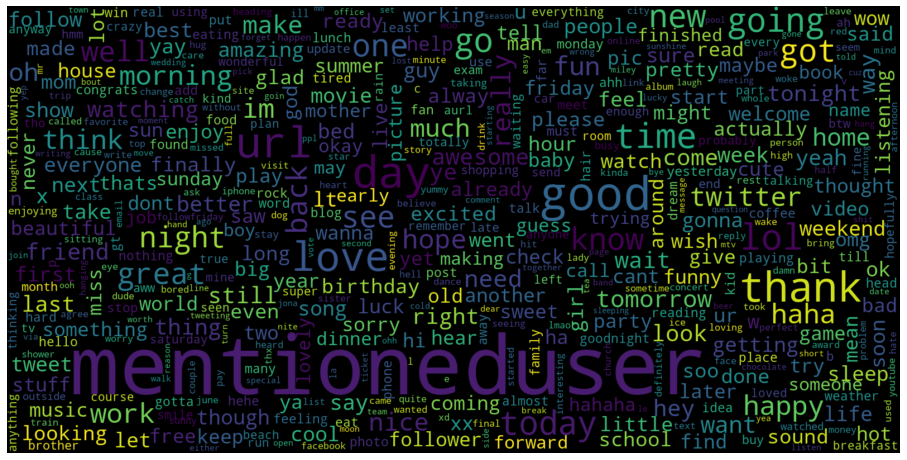

In [20]:
plt.figure(figsize = (16,16))
positive_wc = WordCloud(max_words        = 500,
                        width            = 1600,
                        height           = 800,
                        background_color = 'black',
                        collocations     = False).generate(' '.join(positive_tweets))
plt.imshow(positive_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### 3.2. Negative word cloud <a class="anchor" id="head-32"></a>

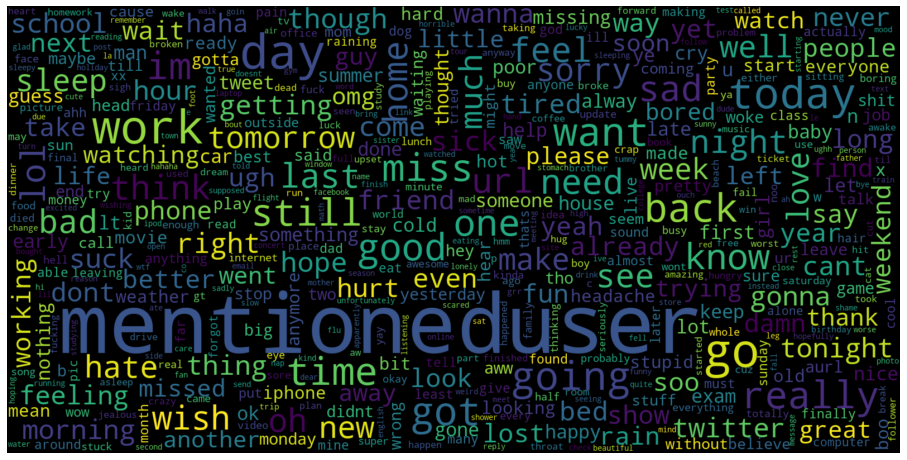

In [21]:
plt.figure(figsize = (16,16))
negative_wc = WordCloud(max_words        = 500,
                        width            = 1600,
                        height           = 800,
                        background_color = 'black',
                        collocations     = False).generate(' '.join(negative_tweets))
plt.imshow(negative_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# 4. Train-test split <a class="anchor" id="head-4"></a>

We will train the model using 70% of the data and validate its performance using the remaining 30%.

In [22]:
X = processed_text['processed_text'].tolist()
y = processed_text['sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

140000
140000
60000
60000


# 5. Term frequency-inverse document frequency <a class="anchor" id="head-5"></a>

TF-IDF is a statistical measure that reflects the importance and relevance of each word in a tweet in relation to the entire collection of tweets. It is the product of two statistics, namely term frequency and inverse document frequency:

* <b>Term frequency</b>: Measures the frequency of a word in a tweet; it can be computed as the number of times a word appear in a tweet divided by the total number of words in the tweet
* <b>Inverse document frequency</b>: Measures how rare a word is in relation to the entire collection of tweets; it can be computed as the total number of tweets divided by the number of tweets that contain the word, then calculating its logarithm

Calculating the product of these two statistics for every word in a tweet will tell us how important and relevant each word is in that tweet. We will be using [<b>TfidfVectorizer</b>](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from scikit-learn to perform this computation.

Subsequently, we will run a few machine learning algorithms on the transformed data and compare their results:

* [<b>Logistic regression</b>](#head-51)
* [<b>Support vector classifier</b>](#head-52)
* [<b>Naive Bayes classifier</b>](#head-53)

All three models performed quite similar in terms of accuracy, with logistic regression reporting the highest accuracy at <b>77.2%</b>. This means that out of every four tweets, our model is able to accurately predict the sentiments of approximately three of them. Not bad for a simple model!

The confusion matrix for each model is also generated. Other than accuracy, an equally important metric to consider is the false positive rate, i.e. how many of the actual negative sentiments are we incorrectly predicting as positive? Brands might want to take a more conservative approach when deploying a sentiment analysis model and select one that results in the lowest false positive rate. In this regard, both logistic regression and naive Bayes classifier are preferable to support vector classifier.

In [23]:
unique_word_list = []

for i in X:
    for j in i.split():
        unique_word_list.append(j)

unique_word_list = set(unique_word_list)

print('Total Number of Unique Words:', len(unique_word_list))

Total Number of Unique Words: 71231


In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
vectorizer.fit(X_train)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(140000, 30000)
(60000, 30000)


In [25]:
tfidf_example = ['i love to eat apples',
                 'i hate vegetables',
                 'this cake is so delicious',
                 'apples taste delicious']

vectorizer_example = TfidfVectorizer()
vectorizer_example.fit(tfidf_example)

tfidf_example = vectorizer_example.transform(tfidf_example)
feature_names = vectorizer_example.get_feature_names()
dense         = tfidf_example.todense()
dense_list    = dense.tolist()
tfidf_final   = pd.DataFrame(dense_list, columns=feature_names)

tfidf_final

,apples,cake,delicious,eat,hate,is,love,so,taste,this,to,vegetables
0,0.414289,0.000000,0.000000,0.525473,0.000000,0.000000,0.525473,0.000000,0.000000,0.000000,0.525473,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107
2,0.000000,0.465162,0.366739,0.000000,0.000000,0.465162,0.000000,0.465162,0.000000,0.465162,0.000000,0.000000
3,0.526405,0.000000,0.526405,0.000000,0.000000,0.000000,0.000000,0.000000,0.667679,0.000000,0.000000,0.000000


### 5.1. Logistic regression <a class="anchor" id="head-51"></a>

In [26]:
def model_evaluation(model):
    y_pred = model.predict(X_test_tfidf)
    print('Accuracy on Test Set:', round(model.score(X_test_tfidf, y_test), 3))
    
    cm = confusion_matrix(y_test, y_pred)
    
    categories        = ['Negative', 'Positive']
    group_names       = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts      = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,
                annot       = labels,
                annot_kws   = {'size': 16},
                cmap        = 'Blues',
                fmt         = '',
                xticklabels = categories,
                yticklabels = categories)
    
    plt.xlabel('Predicted Sentiments', fontsize=18, fontweight='bold')
    plt.ylabel('Actual Sentiments'   , fontsize=18, fontweight='bold')
    plt.show()

Accuracy on Test Set: 0.772


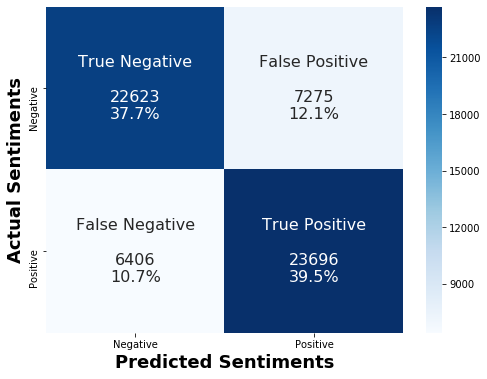

In [27]:
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train_tfidf, y_train)
model_evaluation(LR_model)

### 5.2. Support vector classifier <a class="anchor" id="head-52"></a>

Accuracy on Test Set: 0.759


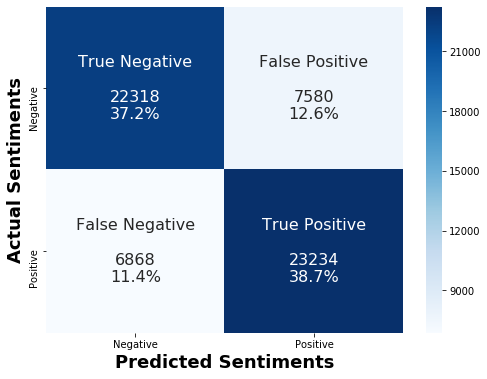

In [28]:
SVC_model = LinearSVC()
SVC_model.fit(X_train_tfidf, y_train)
model_evaluation(SVC_model)

### 5.3. Naive Bayes classifier <a class="anchor" id="head-53"></a>

Accuracy on Test Set: 0.761


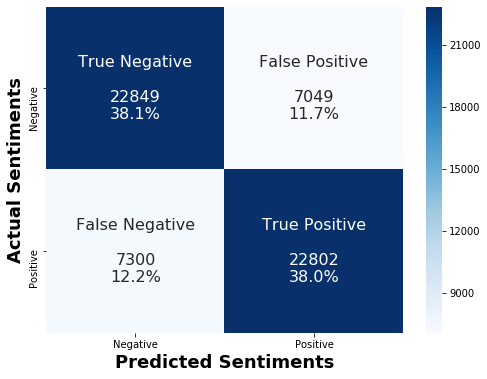

In [29]:
NB_model = MultinomialNB()
NB_model.fit(X_train_tfidf, y_train)
model_evaluation(NB_model)

# 6. Word embedding <a class="anchor" id="head-6"></a>

Word embedding is a technique used to represent words using vectors of real numbers, where similar words will have similar vector representations. It allows us to perform algebraic manipulations on the vectors and obtain arithmetic results such as:

> <i>King - Man = Queen - Woman</i>
>
> <i>France - Paris = Italy - Rome</i>

Some of the more popular pre-trained word embeddings that are available for free include Google's [<b>Word2vec</b>](https://code.google.com/archive/p/word2vec/) and Stanford's [<b>GloVe</b>](https://nlp.stanford.edu/projects/glove/).

### 6.1. GloVe: Global vectors for word representation <a class="anchor" id="head-61"></a>

For our sentiment analysis model, we will use the pre-trained word embeddings from GloVe.

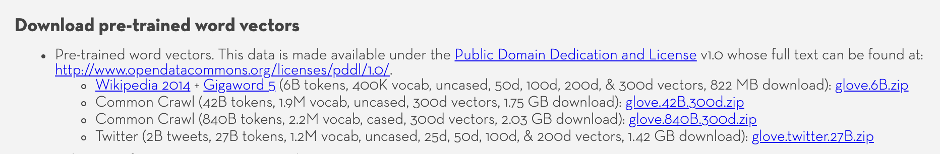

There are four different pre-trained word embeddings that differ in their text source and size. We will be using the first (and smallest) one: <b>glove.6B.zip</b>.

In [30]:
# Download the data.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-01-16 15:05:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-16 15:05:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-16 15:05:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [31]:
# Define key parameters here.
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM       = 100
BATCH_SIZE          = 128
EPOCHS              = 30

In [33]:
# Load the word vectors.
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word   = values[0]
    coefs  = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [34]:
# Get the vocabulary size.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary Size:', vocab_size)

Vocabulary Size: 57674


In [35]:
# Pad the data so that all tweets have the same sequence length.
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH)
X_test_padded  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen = MAX_SEQUENCE_LENGTH)

print(X_train_padded.shape)
print(X_test_padded.shape)

# Print the first example.
print(X_train[0])
print(X_train_padded[0])

(140000, 30)
(60000, 30)
feel useless itching live 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   36 2638
 4447  190]


In [36]:
# Prepare the embedding layer.
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights      = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable    = False)

### 6.2. Long short-term memory networks <a class="anchor" id="head-62"></a>

A <b>recurrent neural network (RNN)</b> is a class of artificial neural networks used in deep learning that is specifically designed to model temporal or sequential data such as speech, text or time series data. <b>Long short-term memory (LSTM)</b> is a special type of RNN that introduces gates and memory cells that can remember information for long periods of time, thus allowing the neural network to learn longer-term dependencies found in the data.

We will train an LSTM network using a simple model architecture comprising:

* <b>Embedding layer</b> (GloVe word embeddings)
* <b>A pair of bidirectional LSTMs</b> (To preserve information from both past and future)
* <b>Dense layer</b>
* <b>Dropout layer</b>
* <b>Dense layer</b> (Sigmoid function for output)

The LSTM network performed very similar to the previous three models with an accuracy of <b>77.2%</b>. Given that we used a simple model architecture with no hyperparameter tuning, the results could potentially be better if we experiment with more iterations.

In [37]:
keras.backend.clear_session()

model = Sequential()

model.add(embedding_layer)
model.add(Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4, return_sequences=False)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss      = 'binary_crossentropy',
              optimizer = 'adam',
              metrics   = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           5767400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,954,857
Trainable params: 187,457
Non-trainable params: 5,767,400
______________________________________

In [38]:
history = model.fit(X_train_padded, y_train,
                    validation_data = (X_test_padded, y_test),
                    batch_size      = BATCH_SIZE,
                    epochs          = EPOCHS,
                    shuffle         = True)

Train on 140000 samples, validate on 60000 samples
Epoch 1/30
140000/140000 [==============================] - 270s 2ms/step - loss: 0.6018 - accuracy: 0.6718 - val_loss: 0.5481 - val_accuracy: 0.7192
Epoch 2/30
140000/140000 [==============================] - 241s 2ms/step - loss: 0.5652 - accuracy: 0.7057 - val_loss: 0.5300 - val_accuracy: 0.7364
Epoch 3/30
140000/140000 [==============================] - 267s 2ms/step - loss: 0.5487 - accuracy: 0.7189 - val_loss: 0.5159 - val_accuracy: 0.7423
Epoch 4/30
140000/140000 [==============================] - 256s 2ms/step - loss: 0.5388 - accuracy: 0.7270 - val_loss: 0.5083 - val_accuracy: 0.7481
Epoch 5/30
140000/140000 [==============================] - 242s 2ms/step - loss: 0.5341 - accuracy: 0.7308 - val_loss: 0.5046 - val_accuracy: 0.7509
Epoch 6/30
140000/140000 [==============================] - 241s 2ms/step - loss: 0.5274 - accuracy: 0.7358 - val_loss: 0.5018 - val_accuracy: 0.7538
Epoch 7/30
140000/140000 [=======================

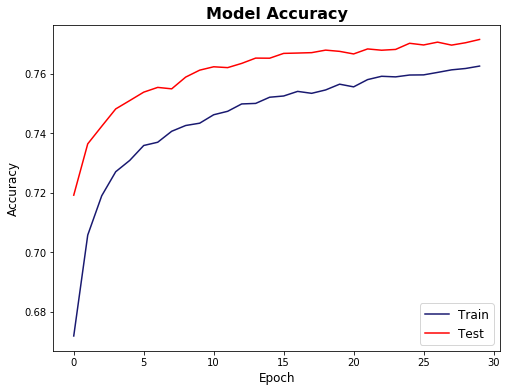

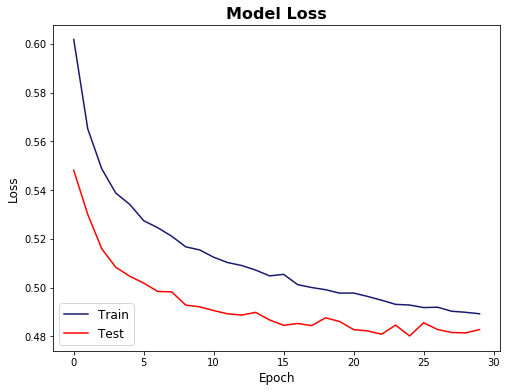

In [39]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy']    , color='midnightblue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('Model Accuracy', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Test'], loc='lower right', fontsize=12)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history.history['loss']    , color='midnightblue')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model Loss', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Test'], loc='lower left', fontsize=12)
plt.show()

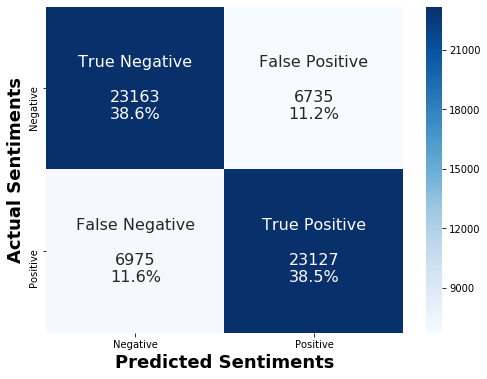

In [40]:
def LSTM_sentiment(prob):
    return 1 if prob > 0.5 else 0

LSTM_prob   = model.predict(X_test_padded)
y_pred_LSTM = [LSTM_sentiment(prob) for prob in LSTM_prob]

LSTM_cm = confusion_matrix(y_test, y_pred_LSTM)

categories        = ['Negative', 'Positive']
group_names       = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts      = ['{0:0.0f}'.format(value) for value in LSTM_cm.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in LSTM_cm.flatten() / np.sum(LSTM_cm)]
labels = [f'{v1}\n\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(8,6))
sns.heatmap(LSTM_cm,
            annot       = labels,
            annot_kws   = {'size': 16},
            cmap        = 'Blues',
            fmt         = '',
            xticklabels = categories,
            yticklabels = categories)

plt.xlabel('Predicted Sentiments', fontsize=18, fontweight='bold')
plt.ylabel('Actual Sentiments'   , fontsize=18, fontweight='bold')
plt.show()

# 7. Implementation <a class="anchor" id="head-7"></a>

In the final section, we will attempt to use our sentiment analysis model (based on logistic regression) to predict the sentiments of a few sample tweets.

Nine out of ten predicted sentiments turned out to be accurate! The fifth tweet should have been classified as positive:

> <i>Can't wait for my long-awaited trip to Japan!!! :)</i>

In [41]:
def predict_sentiment(vectorizer, model, tweet):
    processed_text = text_preprocessing(tweet)
    processed_text = processed_text['processed_text'].tolist()
    processed_text = vectorizer.transform(processed_text)
    sentiment_pred = model.predict(processed_text)
    
    df = []
    for text, prediction in zip(tweet.text.tolist(), sentiment_pred):
        df.append((text, prediction))
    df = pd.DataFrame(df, columns = ['Tweet', 'Sentiment'])
    df = df.replace([0,1], ['Negative', 'Positive'])
    
    return df

In [42]:
tweets = ['@vinnymilktea I hate eating vegetables!',
          '@coldplay Their music is awesome!!!',
          'I would never go back to Shake Shack again. Their burgers suck big time!',
          'Studying is soooo tiring. I had rather go play basketball.',
          "Can't wait for my long-awaited trip to Japan!!! :)",
          'Your customer service is sooooo bad. How can you expect me to wait for 1 hour?! smh srsly',
          "When is this pandemic going to end... I'm so sick of staying at home.",
          'Salary is in!! Time to splurge on my favourite food at Haidilao huat ah',
          'OMG Flower of Evil is truly the best drama of 2020!!!',
          'I belong to Team Han Ji Pyeong!!! HJP all the way!!']
tweets = pd.DataFrame(tweets, columns=['text'])

predict_sentiment(vectorizer, LR_model, tweets)

,Tweet,Sentiment
0,@vinnymilktea I hate eating vegetables!,Negative
1,@coldplay Their music is awesome!!!,Positive
2,I would never go back to Shake Shack again. Th...,Negative
3,Studying is soooo tiring. I had rather go play...,Negative
4,Can't wait for my long-awaited trip to Japan!!...,Negative
5,Your customer service is sooooo bad. How can y...,Negative
6,When is this pandemic going to end... I'm so s...,Negative
7,Salary is in!! Time to splurge on my favourite...,Positive
8,OMG Flower of Evil is truly the best drama of ...,Positive
9,I belong to Team Han Ji Pyeong!!! HJP all the ...,Positive


# 8. Conclusion <a class="anchor" id="head-8"></a>

From the results above, we arrive at the following key points regarding the sentiment analysis model:

1. We can develop a decent sentiment analysis model using either <b>TF-IDF</b> or <b>word embeddings</b> as features.
2. The average <b>accuracy</b> of the top two models (logistic regression and LSTM network) is <b>77%</b> on the test set, which means that out of every four tweets, our models are able to accurately predict the sentiments of three of them.
3. The average <b>false positive rate</b> of the top two models is <b>23%</b> on the test set, which means that out of every four negative tweets, our models will incorrectly predict one of them as positive.

The performance of the models can potentially be improved via the following methods:

1. <b>Sample size</b>: Train on the entire collection of 1.6 million tweets instead of just using a small subset of 200,000 tweets due to limited computing power.
2. <b>TF-IDF</b>: Experiment with different hyperparameter values for 'ngram_range' and 'max_features' in TfidfVectorizer.
3. <b>Word embedding</b>: Try out other word embeddings such as Word2vec or other versions of GloVe.
4. <b>Hyperparameter tuning</b>: Conduct hyperparameter tuning for logistic regression, support vector classifier, Naive Bayes classifier and LSTM network.
5. <b>Model architecture</b>: Experiment with different model architectures for LSTM network.

With a sentiment analysis model, companies will be able to accurately identify the public sentiment towards their brands in real time. This will then allow them to come up with timely strategic changes and key improvements to their products or services which will help in maximising customer satisfaction.